# Sehgal Radio Sources

Implementing new models like radio sources in the `xgpaint.jl` framework is trivial (I hope). Actually, it'll be really interesting to see what parts of are shared between CIB and radio. This will inform the architecture of the final code package.

# 1. Read a Catalog

We operate with HDF5. I convert the `.pksc` format into `.hdf5` in the `pksc2hdf5.py` script (needs some work).

In [1]:
using PyPlot
PyPlot.svg(true);

In [2]:
using HDF5
using SharedArrays
using Healpix
using PoissonRandom
using Distributions
using Interpolations
using QuadGK
using Base.GC
using Roots
using Cosmology
using Unitful
using UnitfulAstro
using Random

In [3]:
const NPROCS = 20

using Distributed
addprocs(NPROCS);

In [4]:
@everywhere begin
    using HDF5
    using SharedArrays
    using Healpix
    using PoissonRandom
    using Distributions
    using Interpolations
    using QuadGK
    using Base.GC
    using Roots
    using Cosmology
    using Unitful
    using UnitfulAstro
    using Random
    # set different seeds for worker IDs
    Random.seed!(myid() + trunc(Int64, time()))
end

The radio sources do not have "centrals" or "satellites". They just live in the halos. Hence, we are storing instead `halo_n_I` and `halo_n_II`, the halo occupation numbers.

In [5]:
@time begin
    hdata = h5open("/tigress/zequnl/xgpaint/websky_halos-light.hdf5", "r") do file
        read(file, "halos")
    end
end

 10.230117 seconds (1.68 M allocations: 12.942 GiB, 0.54% gc time)


4×862923142 Array{Float32,2}:
 -4354.27        -4354.81        …  2732.32        2737.42      
 -4363.68        -4413.0            5731.19        5771.86      
 -4565.72        -4523.77           1922.01        1922.07      
     7.39343e12      5.46722e12        1.19273e12     1.15381e12

In [6]:
@time begin
    mass_cut = hdata[4,:] .> 1e13
    N_halos = sum(mass_cut)
    
    halo_x_pos = SharedArray{Float32}(N_halos)
    halo_y_pos = SharedArray{Float32}(N_halos)
    halo_z_pos = SharedArray{Float32}(N_halos)
    halo_mass = SharedArray{Float32}(N_halos)
    
    # fill up known quantities
    
    halo_x_pos .= hdata[1,mass_cut]
    halo_y_pos .= hdata[2,mass_cut]
    halo_z_pos .= hdata[3,mass_cut]
    halo_mass .= hdata[4,mass_cut]
    hdata = 0
    @everywhere GC.gc()
    
    # derived parameters
    halo_comoving_dist = SharedArray{Float32}(N_halos)
    halo_redshift = SharedArray{Float32}(N_halos)
    
    halo_n_I = SharedArray{Int32}(N_halos)
    halo_n_II = SharedArray{Int32}(N_halos)
end;

 15.713367 seconds (6.26 M allocations: 4.326 GiB, 3.02% gc time)


In [7]:
# f = open("/tigress/zequnl/xgpaint/halo_nbody.binary")
# buffer = Array{Float32}(undef,20,1414339)
# read!(f, buffer )

# f = open("/tigress/zequnl/xgpaint/halo_low_mass.binary")
# buffer2 = Array{Float32}(undef,20,6431049)
# read!(f, buffer2 )

# buffer = hcat( (buffer, buffer2)... )

# sehgal_nbody_mass = buffer[11,:]
# sehgal_nbody_redshift = buffer[1,:];

In [8]:
@everywhere begin
    using PyCall
    astropy_cosmology = pyimport("astropy.cosmology")
end

In [9]:
@everywhere function build_z2ρ_interpolator()
    """
    Construct a fast r2z linear interpolator.
    """
    zrange = LinRange(0.0, 6.0, 1000)
    ρrange = [astropy_cosmology.WMAP9.critical_density.(z)
        for z in zrange];
    z2ρ = LinearInterpolation(zrange, ρrange);
    return z2ρ
end

@everywhere const z2ρ = build_z2ρ_interpolator();

We specify the parameters here. We're taking the model parameters straight from Table 2 of Sehgal et al. 2009.

![pasted image](data/table.png)

In [10]:
@everywhere begin
    # sehgal model parameters
    
    # these coefficients are shared for type I and II
    const a_0   = 0.0
    const a_1_dist = Uniform(-0.12,  0.07)
    const a_2_dist = Uniform(-0.34,  0.99)
    const a_3_dist = Uniform(-0.75, -0.23)
    
    const I_R_int = 10^(-2.6)
    const I_γ = 6.0
    const I_N_0 = 1.0
    const I_M_0 = 4e13
    const I_α = 0.1
    const I_L_b = 10^(24.0)
    const I_m = -1.55
    const I_n = 0.0
    const I_δ = 3.0
    const I_z_p = 0.8
    
    const II_R_int = 10^(-2.8)
    const II_γ = 8.0
    const II_N_0 = 0.015
    const II_M_0 = 3e15
    const II_α = 0.1
    const II_L_b = 10^(27.5)
    const II_m = -1.6
    const II_n = -0.65
    const II_z_p = 1.3
    const II_σ_l = 0.4
    const II_σ_h = 0.73
    
    I_L_min = 2.5e23
    II_L_min = 4e23
    
    
    # output
    const nside   = 4096
    
    # physical constants
    const phys_h     = 6.62606957e-27   # erg.s
    const phys_c     = 3e+10            # cm/s
    const phys_k     = 1.3806488e-16    # erg/K
    const phys_Msun  = 2e33             # g
    const phys_Mpc   = 3.086e24         # cm
    
    # cosmology
    const omegab  = 0.043
    const omegac  = 0.207
    const omegam  = omegab + omegac
    const h = 0.7
    const rhocrit = 2.78e11 * omegam * (h^2)
    const T_CMB = 2.725
    const jl_cosmo = cosmology(h=h, OmegaM=omegam)
end

In [11]:
@everywhere function build_r2z_interpolator()
    """
    Construct a fast r2z linear interpolator.
    """
    zrange = LinRange(0.0, 6.0, 1000)
    rrange = [ustrip(comoving_radial_dist(u"Mpc", jl_cosmo, z))
        for z in zrange];
    r2z = LinearInterpolation(rrange, zrange);
    return r2z
end

@everywhere const r2z = build_r2z_interpolator();

In [12]:
function fill_halovars!(
        x, y, z, # inputs
        redshift_result, dist_result) # outputs
    """
    This function computes distance and redshift in parallel.
    """
    
    N_halos = size(x,1)
    @sync @distributed for i = 1:N_halos
        dist_result[i] = sqrt(x[i]^2 + y[i]^2 + z[i]^2)
        redshift_result[i] = r2z(dist_result[i])
    end
end

fill_halovars! (generic function with 1 method)

We compute the comoving distance, spherical coordinates, and redshift of the halos and store them in the shared memory array `halo_derived`. It's in parallel, so it takes just seconds!

In [13]:
@time fill_halovars!(halo_x_pos, halo_y_pos, halo_z_pos,
    halo_redshift, halo_comoving_dist)

  8.664241 seconds (2.56 M allocations: 132.266 MiB, 0.53% gc time)


Task (done) @0x00002ba4c7a9bd00

In [14]:
@everywhere GC.gc()

---

In [15]:
# function get_ratios(redshift_intervals)
#     i = 1
#     fig, axes = subplots(7,1,figsize=(6,24))
#     nbins = 20
#     ratio = Array{Float64}(undef,7,nbins)
    
#     bins = Array{Float64}(undef, nbins+1)
#     for (zl, zr) in redshift_intervals

#         figure(figsize=(6,3))
#         sehgal_cut = (sehgal_nbody_redshift .> zl) .& (sehgal_nbody_redshift .< zr)
#         val_s, bin_s = axes[i].hist( 
#             log10.(sehgal_nbody_mass[sehgal_cut]), 
#             histtype="step", weights=(8.0 .* ones(sum(sehgal_cut))), label="sehgal", range=(12.0,14.0), bins=nbins )
#         val_w, bin_w = axes[i].hist( log10.(halo_mass[(halo_redshift .> zl) .& (halo_redshift .< zr)]), 
#             histtype="step", label="websky", range=(12.0,14.0), bins=20 )

#         ratio[i,:] .= (val_s ./ val_w)
#         bins .= bin_w
#         axes[i].set_yscale("log")
#         axes[i].set_title("\$ $zl < z < $zr \$")
#         axes[i].legend()

#         i += 1
#     end
#     tight_layout()
    
#     return bins, ratio
# end


# # plot(bin_s[2:end], val_s)
# # plot(bin_w[2:end], val_w)
# # yscale("log")

# # plot(bin_s[2:end], val_s ./ val_w)
# # # plot(bin_w[2:end], )
# # yscale("log")

In [16]:
# ints = [ (0.0, 0.5), (0.5,1.0), (1.0, 1.5), (1.5, 2.0), (2.0, 2.5), (2.5, 3.0), (3.0, 4.0) ]
# massbins, r = get_ratios(ints)

In [17]:
# for i in 1:size(r,1)
#     for j in 1:size(r,2)
#         if isnan(r[i,j])
#             r[i,j] = 0.0
#         end
#     end
# end

In [18]:
# for i in 1:7
#     plot(massbins[2:end], r[i,:], label="$(ints[i])")
# end

# mx = collect(12:0.01:14.0)
# plot( mx, 1. ./ ( 1. .+ exp.( 14*(13 .- mx) ) ), "k--", label="factor")
# legend()
# yscale("log")

# 2. HOD
We assign a number of satellites to each halo. Sehgal assumes the halo occupation number (HON) is given by
$$ N(M) = N_0 (M / M_0)^{\alpha}.$$

In [19]:
@everywhere begin
    pdf_norm1(x, μ, σ) = exp( -(x-μ)^2 / (2 * σ^2) );

    function FR_I_redshift_evolution(z)
        if z < I_z_p
            return (1+z)^I_δ
        else
            return (1+I_z_p)^I_δ
        end
    end

    function FR_II_redshift_evolution(z)
        norm = pdf_norm1(0, II_z_p, II_σ_l)
        if z < II_z_p
            return pdf_norm1(z, II_z_p, II_σ_l) / norm
        else
            return pdf_norm1(z, II_z_p, II_σ_h) / norm
        end
    end
end

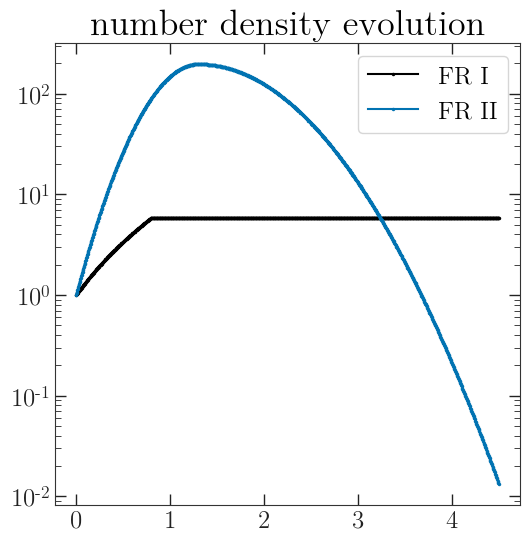

PyObject <matplotlib.legend.Legend object at 0x2ba85c72be10>

In [20]:
zt = LinRange(0.0, 4.5, 1000)

plot(zt, FR_I_redshift_evolution.(zt), label="FR I")
plot(zt, FR_II_redshift_evolution.(zt), label="FR II")

yscale("log")
title("number density evolution")
legend()

In [21]:
function hod_sehgal(n_I_result, n_II_result,
        halo_mass::SharedArray, z::SharedArray)
    # computes sehgal HOD and generates a Poisson draw
    N_halos = size(halo_mass,1)
    
    n_I_result .= 0
    n_II_result .= 0
    
    @sync @distributed for i = 1:N_halos
        
        artificial_halo_factor = 1. / ( 1. + exp( 14.0*(13.0 - log10(halo_mass[i])) ) )
        
        if rand() < artificial_halo_factor
            I_HON = I_N_0 * (halo_mass[i] / I_M_0)^I_α 
            I_HON *= FR_I_redshift_evolution(z[i])
            n_I_result[i] = pois_rand(convert(Float64, I_HON))

            II_HON = II_N_0 * (halo_mass[i] / II_M_0)^II_α
            II_HON *= FR_II_redshift_evolution(z[i])
            n_II_result[i] = pois_rand(convert(Float64, II_HON))
        end
    end
    
end

hod_sehgal (generic function with 1 method)

In [22]:
@time hod_sehgal(halo_n_I, halo_n_II, halo_mass, halo_redshift)

  1.774529 seconds (610.51 k allocations: 31.793 MiB, 0.42% gc time)


Task (done) @0x00002ba4cb570760

In [23]:
println( sum(halo_n_I[halo_redshift .< 0.3]), ", ",
    sum(halo_n_II[halo_redshift .< 0.3]) )

2145525, 62625


# 3. Halos to Sources to Maps

This is a loop *for each halo*, which does the following.

```
for loop over $n_{halo}$
    for loop over $n_{sat}$ of the halo
        do tasks
```

### Tasks
1. draw a random source
2. assign it a luminosity 
3. convert that luminosity to a flux
4. map to a healpix pixel index and add that flux

The Sehgal LF is

$$ p(L) = \begin{cases}   (L/L_b)^m &  L > L_b \\  (L/L_b)^n & \mathrm{otherwise} \end{cases} $$

In [24]:
@everywhere begin
    function sehgal_LFn0(m, Lb; Lmin=1e22)
        crossover = log( Lb/Lmin )
        x = rand() * (-(1/m)+log(Lb/Lmin))
        if x < crossover
            return exp(x) * Lmin
        else
            return Lb * (1+m * x + m * log(Lmin/Lb))^(1/m)
        end
    end
    
    function sehgal_LF(m, n, Lb; Lmin=1e22)
        if n == 0.0
            return sehgal_LFn0(m, Lb; Lmin=Lmin)
        end
        crossover = (1.0 - Lb^-n * Lmin^n)/n
        x = rand() * (m-Lb^(-n) * Lmin^n * m-n)/(m * n)
        if x < crossover
            return (Lmin^n + Lb^n * n * x)^(1/n)
        else
            return Lb * (1.0 + (m * (-1.0 + (Lmin/Lb)^n + n * x))/n)^(1.0/m)
        end
    end
end

In [25]:
using DelimitedFiles

In [26]:
sehgal_red = readdlm("data/sehgal_figure8_red.txt", ',', Float64, '\n')
sehgal_blue = readdlm("data/sehgal_figure8_blue.txt", ',', Float64, '\n')
sehgal_green = readdlm("data/sehgal_figure8_green.txt", ',', Float64, '\n')

5×2 Array{Float64,2}:
 1.89183e25  8.58366e-6 
 5.94557e25  1.11558e-6 
 1.89769e26  8.05405e-8 
 5.964e26    2.83443e-8 
 5.98249e27  8.47917e-10

In [27]:
using CSVFiles, DataFrames

We have a physical measured flux. We need to get the intrinsic luminosity, given the redshift.

In [28]:
# raw_3crr = DataFrame(load(File(format"CSV", "data/3crr.dat"), spacedelim=true, header_exists=true));
# raw_3crr[1:3,:]

Recall that the differential flux $S_{\nu}$ is related to the differential luminosity $L_{\nu} \, [W/Hz]$, by

$$ S_{\nu} = \frac{L_{(1+z)\nu} }{4 \pi (1+z) D_M^2} .$$

We know the differential flux, as well as the redshift, so we can solve for the intrinsic luminosity. However this means we have to solve for the comoving distance with respect to redshift.

In [29]:
function Lum(ν, S₀, ν₀, z, α)
    DM = comoving_radial_dist(jl_cosmo, z)
    return uconvert( u"W/Hz", 
        4π * S₀ * (ν/ν₀)^(-α) * (1+z)^(1+α) * DM^2
    )
end

Lum (generic function with 1 method)

In [30]:
# raw_3crr[1:4,:Flux178MHz_Jy]
# L_3CRR = Lum.( 151.0u"MHz", raw_3crr[!,:Flux178MHz_Jy]u"Jy", 178u"MHz", raw_3crr[!,:Redshift], raw_3crr[!,:Sp_index] );

# lowz = (raw_3crr[!,:Redshift] .< 0.3)
# FRI_samp = ustrip.( u"W/Hz", L_3CRR[ (raw_3crr[!,:FR_class] .== 1) .& lowz ] )
# FRII_samp = ustrip.( u"W/Hz", L_3CRR[ (raw_3crr[!,:FR_class] .== 2) .& lowz ] );

In [31]:
# perV = 1.0 / ustrip( u"Mpc^3", comoving_volume(jl_cosmo, 0.3) )

In [32]:
# plot( (sehgal_red[:,1]), sehgal_red[:,2], "rp", label="sehgal model")
# plot( (sehgal_green[:,1]), sehgal_green[:,2], color="green", "^", label="fig. 8 FR I")
# plot( (sehgal_blue[:,1]), sehgal_blue[:,2], color="blue", "s", label="fig. 8 FR II")

# xs = 10 .^ collect(24:0.5:29)
# plot( xs, 10e-6 * (xs/1e25) .^ -1.4, "k-", alpha=0.5, label="\$ L^{-1.4} \$")

# xlabel("L [W/Hz]")
# legend()
# yscale("log")
# xscale("log")

In [33]:
"""
Get bin index. Optimized for declining distributions where 
the smaller bin values are more common than the larger bins.
"""

@everywhere function bin_ind(x::T, bin_left_edges::AbstractArray{T,1}) where {T}
    if x < bin_left_edges[1]
        return 1
    end
    for i in 1:length(bin_left_edges)
        if bin_left_edges[i] > x
            return i-1
        end
    end
    return length(bin_left_edges)
end

function bin_vec(vec, bins)
    counter = zeros(Int64, length(bins))
    
    for v in vec
        counter[bin_ind(v, bins)] += 1
    end
    
    return counter
end

bin_vec (generic function with 1 method)

In [34]:
bins = (range(23.9, stop=29.1, step=0.5));

In [35]:
function plot_bins(binlefts, counts)
    xs = vcat(  [[binlefts[i], binlefts[i+1]] for i in 1:(length(binlefts)-1)]... )
    ys = vcat(  [[counts[i], counts[i]] for i in 1:(length(binlefts)-1)]... )
    return xs, ys
end

plot_bins (generic function with 1 method)

In [36]:
# figure(figsize=(8,8))
# bins = (range(23.9, stop=29.1, step=0.5));
# FRI_counts = bin_vec( log10.(FRI_samp), bins )
# xsI, ysI = plot_bins(collect(bins), FRI_counts .* (perV * 2.0))
# plot(xsI, ysI, "g-", alpha=0.4, label="3CRR FR I" )

# bins = (range(23.8, stop=29.0, step=0.5));
# FRII_counts = bin_vec( log10.(FRII_samp), bins )
# xsII, ysII = plot_bins(collect(bins), FRII_counts .* (perV * 2.0))
# plot(xsII, ysII, "b-", alpha=0.4, label="3CRR FR II" )

# bins = (range(23.7, stop=28.9, step=0.5));
# tot_counts = bin_vec( vcat( [log10.(FRI_samp),log10.(FRII_samp)]... ), bins )
# xs, ys = plot_bins(collect(bins), tot_counts  .* (perV * 2.0))
# plot(xs, ys, "r-", alpha=0.4, label="3CRR tot" )

# plot( log10.(sehgal_red[:,1]), sehgal_red[:,2] .* (sehgal_red[:,1] ./ 2e28), "rp", label="fig 8. model \$\\times (P/P_0)\$", alpha=0.6)
# plot( log10.(sehgal_green[:,1]), sehgal_green[:,2] .* (sehgal_green[:,1] ./ 2e28), color="green", "^", label="fig. 8 FR I \$\\times (P/P_0)\$", alpha=0.6)
# plot( log10.(sehgal_blue[:,1]), sehgal_blue[:,2] .* (sehgal_blue[:,1] ./ 2e28), color="blue", "s", label="fig. 8 FR II \$\\times (P/P_0)\$", alpha=0.6)

# ylabel("counts / log bin / Mpc\$^3\$")
# xlabel("\$ \\log L \$")

# ylim(1e-10, 1e-7)
# legend(ncol = 2)
# yscale("log")

# Reproducing the 151 MHz RLF for $z \leq 3$

In [37]:
function make_RLF(n_I, n_II, mass, redshift, counter, bins)
    
    counter .= 0
    @sync @distributed  for i = 1:N_halos
        
        # all sources are smack on the halo
#         ν_Hz = (1+redshift[i]) .* ν_obs_arr
        if redshift[i] < 0.3

            # do it for FR_I
            for j = 1:n_I[i]
                L = sehgal_LF(I_m, I_n, I_L_b; Lmin=I_L_min)
                ind = bin_ind(log10.(L), bins)
                if ind > 0
                    counter[ind] += 1
                end
            end

            # do it for FR_II
            for j = 1:n_II[i]
                L = sehgal_LF(II_m, II_n, II_L_b; Lmin=II_L_min)
                ind = bin_ind(log10.(L), bins)
                if ind > 0
                    counter[ind] += 1
                end
            end
        end
        
    end
end

make_RLF (generic function with 1 method)

In [38]:
bins = (range(24, stop=29, step=0.05));
counter = SharedArray{Int64}(length(bins));
make_RLF(halo_n_I, halo_n_II, halo_mass, halo_redshift, counter, bins)

Task (done) @0x00002ba4ca049870

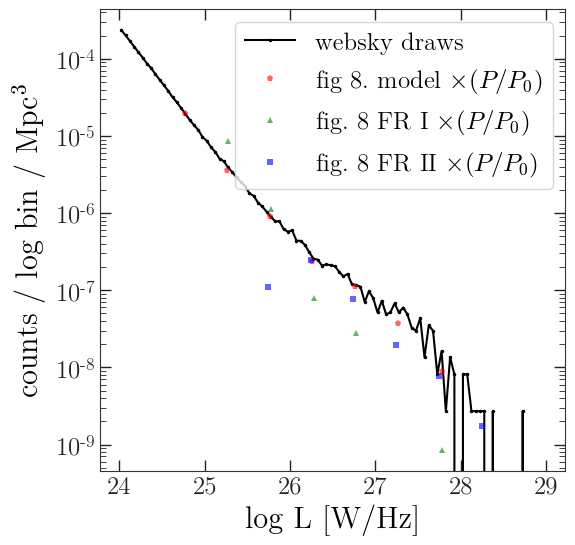

PyObject <matplotlib.legend.Legend object at 0x2ba505ac15d0>

In [39]:
vol = ustrip(u"Mpc^3",comoving_volume( jl_cosmo, 0.3))

mids = (bins[2:end] .+ bins[1:end-1]) ./ 2.0
plot(mids, counter[2:end] ./ diff((bins)) ./ vol, label="websky draws" )

ylabel("counts / log bin / Mpc\$^3\$")
xlabel("log L [W/Hz]")
yscale("log")


plot( log10.(sehgal_red[:,1]), sehgal_red[:,2] , "rp", label="fig 8. model \$\\times (P/P_0)\$", alpha=0.6)
plot( log10.(sehgal_green[:,1]), sehgal_green[:,2] , color="green", "^", label="fig. 8 FR I \$\\times (P/P_0)\$", alpha=0.6)
plot( log10.(sehgal_blue[:,1]), sehgal_blue[:,2] , color="blue", "s", label="fig. 8 FR II \$\\times (P/P_0)\$", alpha=0.6)


# plot( bins[2:end], 1e23 .* (10 .^bins[2:end]) .^ -1 )
legend()
# ylim(2e-10, 1e-7)
# xticks(10.0 .^ collect(24:29))

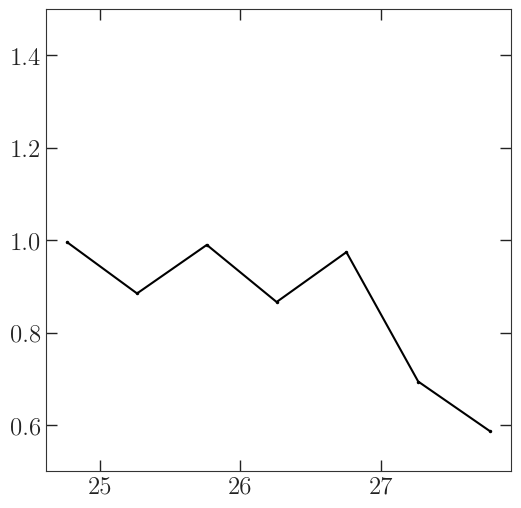

(0.5, 1.5)

In [40]:
interp_linear = LinearInterpolation(mids, counter[2:end] ./ diff((bins)) ./ vol)

plot( log10.(sehgal_red[:,1]), sehgal_red[:,2] ./ interp_linear(log10.(sehgal_red[:,1])) )
ylim(0.5,1.5)

## Lobe/Core and Spectral Shape

We draw a luminosity $L_{beam}$ from $p(L)$ described above. Then we can divide this into two separate components, 

$$ L_{\mathrm{beam}} = L_{c,\mathrm{beam}} + L_{l,\mathrm{int}} . $$

The core-to-lobe flux ratio $R_{\mathrm{obs}} \equiv L_{c,\mathrm{beam}}/L_{l,\mathrm{int}}$ is also randomly generated. We assume a uniform distribution of $\cos \theta$, the angle between the line-of-sight and the jet axis. The inputs here are

1. our random $L_{\mathrm{beam}}$ draw from $p(L)$
2. fixed $R_{\mathrm{int}}$ and $\gamma$ from Wilman et al. 2008 [W08] 
3. a random draw of $\cos \theta \in [0,1]$.

We can then calculate the ratio

$$ R_{\mathrm{obs}} = R_{\mathrm{int}} B(\theta) \quad \quad \beta = \sqrt{1-\gamma^{-2}} $$
$$ B(\theta) = [ (1-\beta \cos \theta)^{-2} + (1 + \beta \cos \theta)^{-2} ] / 2.$$

Now you have the observed ratios, you can write 

$$ L_{c,\mathrm{beam}} = \frac{ R_{\mathrm{obs}} L_{\mathrm{beam}} }{ 1 + R_{\mathrm{obs}} }, \quad \quad L_{l,\mathrm{int}} = \frac{ L_{\mathrm{beam}} }{1 + R_{\mathrm{obs}}}.$$

Each component has its own spectral shape. For $a_i$ drawn from uniform distributions (see table) for each source,

$$ \log f_{\mathrm{core}}(\nu) = \sum_{i=0}^3 a_i \left(\log \frac{\nu}{151 \, \mathrm{MHz}} \right)^i , $$
$$ f_{\mathrm{lobe}}(\nu) = \left( \frac{\nu}{151 \, \mathrm{MHz}} \right)^{-0.8}.$$

We normalize both spectral shapes such that $ f(151 \, \mathrm{MHz}) = 1$ because I'm assuming $p(L)$ is describing the $z \sim 0$, 151 MHz RLF.

In [41]:
@everywhere begin
    B(cosθ, β) = ( (1.0-β*cosθ)^(-2.0) + (1.0+β*cosθ)^(-2.0) ) / 2.0

    function get_core_lobe_lum(L_beam, ν_Hz, R_int, γ, a_1, a_2, a_3, cosθ)
        β = sqrt(1.0-γ^(-2.0))
        R_obs = R_int * B(cosθ, β)
        L_int = L_beam * (1.0 + R_int) / (1.0 + R_obs)
        L_l_int = L_int / (1.0 + R_int)
        L_c_beam = R_obs * L_l_int

        # now put in the frequency dependence. a_0 = 0.0
        lν = log10(ν_Hz / 1e9 ) # normed to 151 MHz
        f_core =  10 ^ ( a_1 * lν + a_2 * lν^2 + a_3 * lν^3 )
        
        lν_norm = log10(151e6 / 1e9 ) # normed to 151 MHz
        norm_core =  10 ^ ( a_1 * lν_norm + a_2 * lν_norm^2 + a_3 * lν_norm^3 )
        
        f_lobe = (ν_Hz / 151e6 ).^(-0.8)
        return L_c_beam * f_core / norm_core, L_l_int * f_lobe
    end
end

In [42]:
@everywhere function l2f(Lum, r_comoving, redshift)
    return Lum / (4π * r_comoving^2 * (1.0 + redshift))
end

In [43]:
function make_source_counts(ν_Hz, d_cm, n_I, n_II, mass, redshift, counterI, counterII, bins; corefac=1.0, lobefac=1.0)
    
    flux_to_Jy = ustrip(u"Jy", 1u"W/Hz*Mpc^-2")
    
    counterI .= 0
    counterII .= 0
    # @sync @distributed  
    @sync @distributed  for i = 1:N_halos
        
        # all sources are smack on the halo
        ν_lum = (1+redshift[i]) .* ν_Hz
        if redshift[i] < 3.0

            # do it for FR_I
            for j = 1:n_I[i]
                L = sehgal_LF(I_m, I_n, I_L_b; Lmin=I_L_min)
                a_1 = rand(a_1_dist)
                a_2 = rand(a_2_dist)
                a_3 = rand(a_3_dist)
                cosθ = rand()
                L_c, L_l = get_core_lobe_lum(L, ν_lum, I_R_int, I_γ,
                    a_1, a_2, a_3, cosθ)
                flux = l2f(L_c*corefac+L_l*lobefac, d_cm[i], redshift[i]) * flux_to_Jy
                ind = bin_ind(log10.(flux), bins)
                if ind > 1
                    counterI[ind] += 1
                end
            end

            # do it for FR_II
            for j = 1:n_II[i]
                L = sehgal_LF(II_m, II_n, II_L_b; Lmin=II_L_min)
                a_1 = rand(a_1_dist)
                a_2 = rand(a_2_dist)
                a_3 = rand(a_3_dist)
                cosθ = rand()
                L_c, L_l = get_core_lobe_lum(L, ν_lum, II_R_int, II_γ,
                    a_1, a_2, a_3, cosθ)
                flux = l2f(L_c*corefac+L_l*lobefac, d_cm[i], redshift[i]) * flux_to_Jy
                ind = bin_ind(log10.(flux), bins)
                if ind > 1
                    counterII[ind] += 1
                end
            end
            
        end
        
    end
end

make_source_counts (generic function with 1 method)

In [44]:
bins = (range(-4.0, stop=2.0, step=0.05));
extra_bins = (range(-4.0, stop=2.05, step=0.05));
counterI = SharedArray{Int64}(length(bins));
counterII = SharedArray{Int64}(length(bins));

In [45]:
# @time make_source_counts(145e9, halo_comoving_dist, halo_n_I, halo_n_II, 
#     halo_mass, halo_redshift, counterI, counterII, bins)

# mids = (extra_bins[2:end] .+ extra_bins[1:end-1]) ./ 2.0
# plot(10 .^ mids, (counterI .+ counterII) .* (10 .^ bins).^2.5 ./ diff(10 .^ extra_bins) / 4π, label="zack" )

# Sehgal145GHz = readdlm("data/sehgal_fig9_145GHz.txt", ',', Float64, '\n');
# plot(Sehgal145GHz[:,1], Sehgal145GHz[:,2], "ro", label="sehgal")

# title("websky 145 GHz")
# yscale("log")
# xscale("log")
# xlabel("\$ S \$ [Jy]")
# xticks(10 .^ [-3.,-2.,-1.,0.,1.])
# legend()

In [46]:
global_corefac = 0.3

0.3

 21.634108 seconds (1.97 M allocations: 103.516 MiB, 0.17% gc time)
 20.395253 seconds (13.16 k allocations: 784.922 KiB)
 23.859531 seconds (13.35 k allocations: 789.094 KiB)


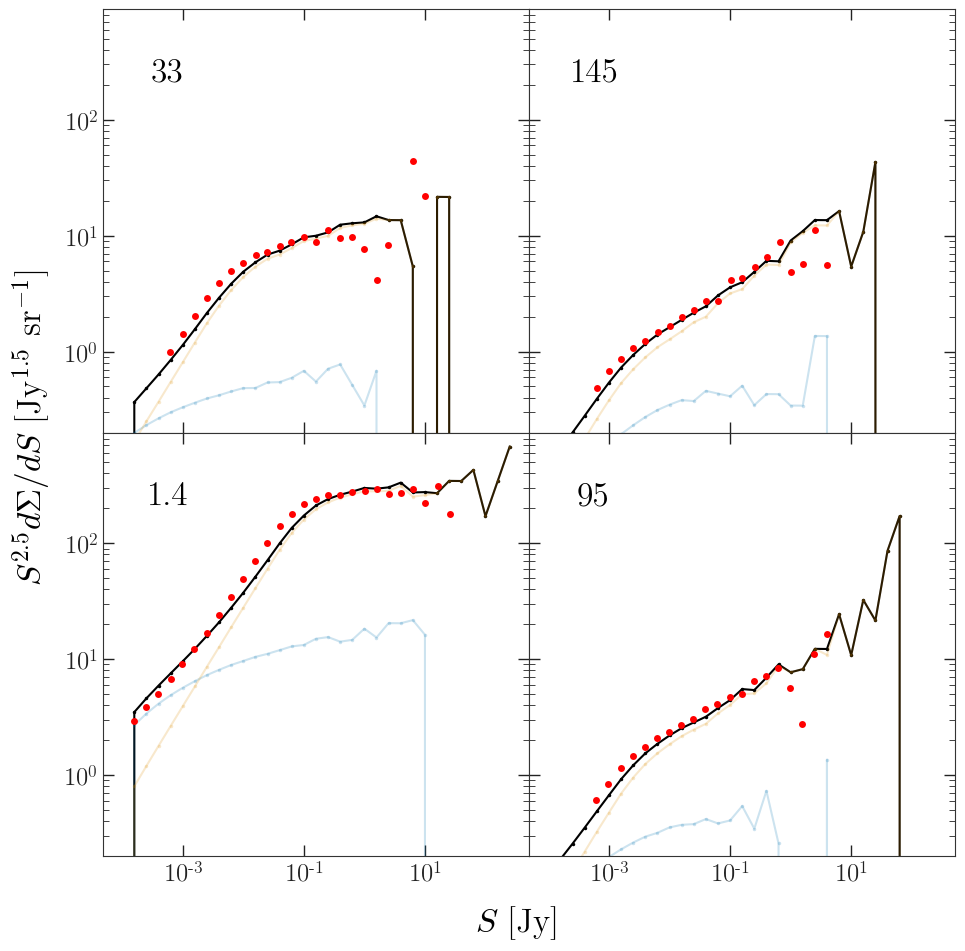

 20.630131 seconds (13.16 k allocations: 786.156 KiB)


In [47]:
# bins = (range(-4.0, stop=2.0, step=0.05));
# extra_bins = (range(-4.0, stop=2.05, step=0.05));

bins = (range(-4.1, stop=2.3, step=0.2));
extra_bins = (range(-4.1, stop=2.5, step=0.2));
counterI = SharedArray{Int64}(length(bins));
counterII = SharedArray{Int64}(length(bins));
mids = (extra_bins[2:end] .+ extra_bins[1:end-1]) ./ 2.0

fig, axes = subplots(2,2,figsize=(11,11), sharex="col", sharey="row")

@time make_source_counts(33e9, halo_comoving_dist, halo_n_I, halo_n_II, 
    halo_mass, halo_redshift, counterI, counterII, bins; corefac=global_corefac)
axes[1,1].plot(10 .^ mids, 
    (counterI .+ counterII) .* (10 .^ mids).^2.5 ./ diff(10 .^ extra_bins) / 4π)
axes[1,1].plot(10 .^ mids, 
    (counterI) .* (10 .^ mids).^2.5 ./ diff(10 .^ extra_bins) / 4π, alpha=0.2)
axes[1,1].plot(10 .^ mids, 
    (counterII) .* (10 .^ mids).^2.5 ./ diff(10 .^ extra_bins) / 4π, alpha=0.2)
Sehgal = readdlm("data/sehgal_fig9_33GHz.txt", ',', Float64, '\n');
axes[1,1].plot(Sehgal[:,1], Sehgal[:,2], "ro", label="sehgal")

@time make_source_counts(145e9, halo_comoving_dist, halo_n_I, halo_n_II, 
    halo_mass, halo_redshift, counterI, counterII, bins; corefac=global_corefac)
axes[1,2].plot(10 .^ mids, 
    (counterI .+ counterII) .* (10 .^ mids).^2.5 ./ diff(10 .^ extra_bins) / 4π)
axes[1,2].plot(10 .^ mids, 
    (counterI) .* (10 .^ mids).^2.5 ./ diff(10 .^ extra_bins) / 4π, alpha=0.2)
axes[1,2].plot(10 .^ mids, 
    (counterII) .* (10 .^ mids).^2.5 ./ diff(10 .^ extra_bins) / 4π, alpha=0.2)
Sehgal = readdlm("data/sehgal_fig9_145GHz.txt", ',', Float64, '\n');
axes[1,2].plot(Sehgal[:,1], Sehgal[:,2], "ro", label="sehgal")

@time make_source_counts(1.4e9, halo_comoving_dist, halo_n_I, halo_n_II, 
    halo_mass, halo_redshift, counterI, counterII, bins; corefac=global_corefac)
axes[2,1].plot(10 .^ mids, 
    (counterI .+ counterII) .* (10 .^ mids).^2.5 ./ diff(10 .^ extra_bins) / 4π)
axes[2,1].plot(10 .^ mids, 
    (counterI) .* (10 .^ mids).^2.5 ./ diff(10 .^ extra_bins) / 4π, alpha=0.2)
axes[2,1].plot(10 .^ mids, 
    (counterII) .* (10 .^ mids).^2.5 ./ diff(10 .^ extra_bins) / 4π, alpha=0.2)
Sehgal = readdlm("data/sehgal_fig9_1.4GHz.txt", ',', Float64, '\n');
axes[2,1].plot(Sehgal[:,1], Sehgal[:,2], "ro", label="sehgal")

@time make_source_counts(95e9, halo_comoving_dist, halo_n_I, halo_n_II, 
    halo_mass, halo_redshift, counterI, counterII, bins; corefac=global_corefac)
axes[2,2].plot(10 .^ mids,
    (counterI .+ counterII) .* (10 .^ mids).^2.5 ./ diff(10 .^ extra_bins) / 4π)
axes[2,2].plot(10 .^ mids, 
    (counterI) .* (10 .^ mids).^2.5 ./ diff(10 .^ extra_bins) / 4π, alpha=0.2)
axes[2,2].plot(10 .^ mids, 
    (counterII) .* (10 .^ mids).^2.5 ./ diff(10 .^ extra_bins) / 4π, alpha=0.2)
Sehgal = readdlm("data/sehgal_fig9_95GHz.txt", ',', Float64, '\n');
axes[2,2].plot(Sehgal[:,1], Sehgal[:,2], "ro", label="sehgal")



freq_list = ["33" "145";
             "1.4" "95"]

for i in 1:2
    for j in 1:2
        axes[i,j].set_yscale("log")
        axes[i,j].set_xscale("log")
        axes[i,j].text(0.15, 0.85, freq_list[i,j],
             horizontalalignment="center",
             verticalalignment="center",
             transform = axes[i,j].transAxes, fontsize=24)
    end
end


axes[1,1].set_ylim(2e-1, 9e2)
axes[2,1].set_ylim(2e-1, 9e2)

fig.text(0.5, 0.05, "\$ S \$ [Jy]", ha="center", va="center", fontsize=24)
fig.text(0.06, 0.5, "\$ S^{2.5} d\\Sigma / dS \$ [Jy\$^{1.5}\$ sr\$^{-1}\$]", ha="center", va="center", fontsize=24,rotation="vertical")

plt.subplots_adjust(wspace=0, hspace=0)

In [48]:
sehgal_radio_cat = DataFrame(load(File(format"CSV", "/tigress/zequnl/xgpaint/radio.cat"), 
        spacedelim=true, header_exists=false, colnames=["ra","dec","z","f_1_4","f_30","f_90", "f_148","f_219","f_277","f_350"]));

In [49]:
bins = (range(-4.1, stop=2.3, step=0.2));
extra_bins = (range(-4.1, stop=2.5, step=0.2));
counter_sehgal = SharedArray{Int64}(length(bins));

for i in 1:length(sehgal_radio_cat[!,:f_1_4])
    ind = bin_ind(log10(sehgal_radio_cat[i,:f_1_4]) - 3.0, bins)
    if ind > 1
        counter_sehgal[ind] += 1
    end
end

mids = (extra_bins[2:end] .+ extra_bins[1:end-1]) ./ 2.0

-4.0:0.2:2.4

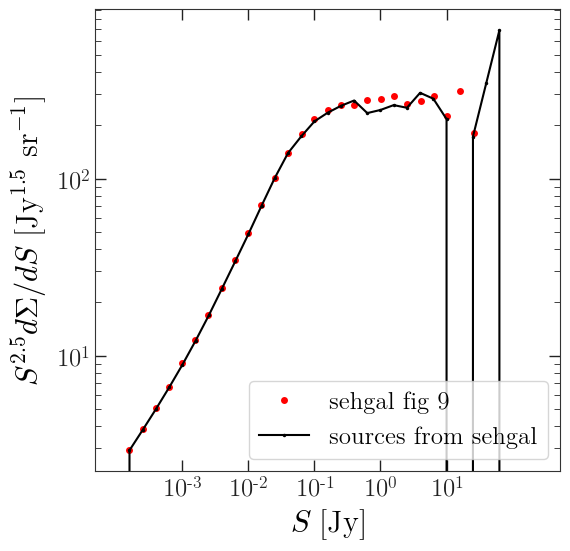

PyObject <matplotlib.legend.Legend object at 0x2ba506800f10>

In [50]:
Sehgal1_4GHz = readdlm("data/sehgal_fig9_1.4GHz.txt", ',', Float64, '\n');
plot(Sehgal1_4GHz[:,1], Sehgal1_4GHz[:,2], "ro", label="sehgal fig 9")
plot(10 .^ mids, counter_sehgal .* (10 .^ mids).^2.5 ./ diff(10 .^ extra_bins) / (4π/8.0), label="sources from sehgal" )


yscale("log")
xscale("log")
xlabel("\$ S \$ [Jy]")
ylabel("\$ S^{2.5} d\\Sigma / dS \$ [Jy\$^{1.5}\$ sr\$^{-1}\$]")
xticks(10 .^ [-3.,-2.,-1.,0.,1.])
legend()

In [51]:
@everywhere const Healpix_res = Resolution(nside)

In [52]:
"""Generate a CIB map given a HOD.

Frequency ν_obs must be in Hz.

Flux cut should be in Jansky
Flux cut freq is in Hz
"""
function make_map(x, y, z, d_cm, redshift, 
        n_I, n_II, ν_obs_arr;        
        debug_mode=false, I_ind=nothing, II_ind=nothing,
        L_I=nothing, L_II=nothing, z_I=nothing, z_II=nothing,
        corefac=0.3, ν_flux_cut_obs=148e9, flux_cut_Jy=7e-3
    )

    
    # multiply a number with units W/Hz/Mpc^2 to get Jy
    WHzMpc_to_Jy = ustrip(u"Jy", 1u"W/Hz*Mpc^-2")
    flux_cut = flux_cut_Jy / WHzMpc_to_Jy # in W/Hz/Mpc^2
    
    N_halos = size(d_cm,1)
    N_freqs = size(ν_obs_arr,1)
    result_map = SharedArray{Float64}((N_freqs,Healpix.nside2npix(nside))); 
    result_map .= 0.0 # initialize to zero
    
    @sync @distributed  for i = 1:N_halos
        
        if redshift[i] < 3.0
            # all sources are smack on the halo
            ν_Hz = (1+redshift[i]) .* ν_obs_arr
            ν_flux_cut = (1+redshift[i]) * ν_flux_cut_obs
            hp_index = Healpix.vec2pixRing(Healpix_res, x[i], y[i], z[i])

            # do it for FR_I
            for j = 1:n_I[i]
                L = sehgal_LF(I_m, I_n, I_L_b; Lmin=I_L_min)
                a_1 = rand(a_1_dist)
                a_2 = rand(a_2_dist)
                a_3 = rand(a_3_dist)
                cosθ = rand()
                
                # compute 150 GHz flux for flux cut
                L_c, L_l = get_core_lobe_lum(L, ν_flux_cut, I_R_int, I_γ, 
                        a_1, a_2, a_3, cosθ)
                flux = l2f(L_c*corefac + L_l, d_cm[i], redshift[i])
                if flux < flux_cut
                    for ν_i in 1:N_freqs
                        L_c, L_l = get_core_lobe_lum(L, ν_Hz[ν_i], I_R_int, I_γ,
                            a_1, a_2, a_3, cosθ)
                        flux = l2f(L_c*corefac + L_l, d_cm[i], redshift[i])
                        result_map[ν_i, hp_index] += flux
                    end
                end
            end

            # do it for FR_II
            for j = 1:n_II[i]
                L = sehgal_LF(II_m, II_n, II_L_b; Lmin=II_L_min)
                a_1 = rand(a_1_dist)
                a_2 = rand(a_2_dist)
                a_3 = rand(a_3_dist)
                cosθ = rand()
                
                # compute 150 GHz flux for flux cut
                L_c, L_l = get_core_lobe_lum(L, ν_flux_cut, II_R_int, II_γ, 
                        a_1, a_2, a_3, cosθ)
                flux = l2f(L_c*corefac + L_l, d_cm[i], redshift[i])
                if flux < flux_cut
                    for ν_i in 1:N_freqs
                        L_c, L_l = get_core_lobe_lum(L, ν_Hz[ν_i], II_R_int, II_γ, 
                            a_1, a_2, a_3, cosθ)
                        flux = l2f(L_c*corefac + L_l, d_cm[i], redshift[i])
                        result_map[ν_i, hp_index] += flux
                    end
                end
            end
        end
        
    end
    
    norm_factor = WHzMpc_to_Jy / Healpix.nside2pixarea(nside)
    return result_map .* norm_factor
end

make_map

In [53]:
freq_list = [30, 93, 145, 217, 280, 353 ] .* 1e9;
# freq_list = [1.4] .* 1e9;

In [54]:
@time result = make_map(
    halo_x_pos, halo_y_pos, halo_z_pos, 
    halo_comoving_dist, halo_redshift,
    halo_n_I, halo_n_II, freq_list;
    
    flux_cut_Jy=1e100
);

 84.162338 seconds (2.22 M allocations: 9.111 GiB, 0.15% gc time)


In [55]:
m = Map{Float64, RingOrder}(nside)
for i in 1:size(freq_list,1)
    filename = "/tigress/zequnl/xgpaint/radio_$(freq_list[i]/1e9).fits"
    try
        run(`rm $filename`)
    catch err
        println(err)
    end
    m.pixels .= result[i,:];
    Healpix.saveToFITS(m, filename)
end

In [56]:
function get_μK_conversion(ν_Hz)
    ν_ = ν_Hz * 1u"Hz"
    c_ = 299792458.0u"m/s"
    h_ = 6.62607015e-34u"J*s"
    k_ = 1.38064852e-23u"m^2 * kg / s^2 / K"
    x = uconvert(Unitful.NoUnits, h_ * ν_ / (k_ * T_CMB * u"K") )

    return uconvert(u"K/Jy",
        c_^2 / (2 * k_ * ν_^2 ) * (expm1(x)^2 / (x^2 * exp(x))))
        
end

get_μK_conversion (generic function with 1 method)

In [57]:
ustrip.( u"μK/Jy", get_μK_conversion.(freq_list) )

6-element Array{Float64,1}:
 0.03701396034733168  
 0.004683509698460815 
 0.002595203002861245 
 0.0020683915234002374
 0.002331542380044927 
 0.0033735887524933045

In [58]:
# @time begin
#     halo_I_ind = SharedArray{Int64}(N_halos)
#     halo_II_ind = SharedArray{Int64}(N_halos)
    
#     function gen_ind(I_ind, II_ind)
#         cI = 0
#         cII = 0
#         for i in 1:N_halos
#             I_ind[i] = cI
#             cI += halo_n_I[i]
#             II_ind[i] = cII
#             cII += halo_n_II[i]
#         end
#     end
    
#     gen_ind(halo_I_ind, halo_II_ind)
# end

In [59]:
# halo_L_I = SharedArray{Float32}(sum(halo_n_I)); 
# halo_L_II = SharedArray{Float32}(sum(halo_n_II)); 
# halo_z_I = SharedArray{Float32}(sum(halo_n_I)); 
# halo_z_II = SharedArray{Float32}(sum(halo_n_II)); 

# @time result = make_map(
#     halo_x_pos, halo_y_pos, halo_z_pos, 
#     halo_comoving_dist, halo_redshift,
#     halo_n_I, halo_n_II, 100e9,
    
#     true, halo_I_ind, halo_II_ind, halo_L_I, halo_L_II, halo_z_I, halo_z_II
# );

In [60]:
# using Plots
# gr()  # Use the GR backend

# logm = Map{Float64, RingOrder}(nside)
# logm.pixels .= log10.(result);
# Plots.plot( logm )

In [61]:
# m = Map{Float64, RingOrder}(nside)
# m.pixels .= result[1,:];
# Healpix.saveToFITS(m, "/tigress/zequnl/xgpaint/radio100.fits")